In [1]:
import pandas as pd
import matplotlib.pyplot as plt

data_path = "./data_sets/"

df_patients= pd.read_csv(data_path + 'PATIENTS.csv.gz')        
df_admissions = pd.read_csv(data_path + 'ADMISSIONS.csv.gz')           # Item descriptions
df_icustays = pd.read_csv(data_path + 'ICUSTAYS.csv.gz')        # ICU stay times
df_diagnoses = pd.read_csv(data_path + 'DIAGNOSES_ICD.csv.gz', low_memory=False) # Chart 


         

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# Filter for Pneumonia (ICD-9 = 48283)
df_target = df_diagnoses[df_diagnoses['ICD9_CODE'] == '48283'][['SUBJECT_ID', 'HADM_ID', 'ICD9_CODE']]

print(df_target.shape)

df_target.head()

(264, 3)


,SUBJECT_ID,HADM_ID,ICD9_CODE
38,114,178393,48283
4202,339,112625,48283
5063,285,165312,48283
7541,605,115545,48283
8075,720,171046,48283


In [ ]:
# Merge with admissions to get LOS
df_merged = pd.merge(
    df_target,
    df_admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'ADMISSION_TYPE']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'
)
print(df_merged.shape)
df_merged.head()

(264, 6)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,DISCHTIME,ADMISSION_TYPE
0,114,178393,48283,2146-08-29 01:18:00,2146-09-03 16:06:00,ELECTIVE
1,339,112625,48283,2187-04-20 23:10:00,2187-06-19 13:20:00,EMERGENCY
2,285,165312,48283,2152-09-21 22:47:00,2152-10-20 15:19:00,EMERGENCY
3,605,115545,48283,2197-11-09 12:59:00,2197-11-26 09:36:00,EMERGENCY
4,720,171046,48283,2160-02-15 21:44:00,2160-04-07 13:05:00,EMERGENCY


In [ ]:
# Calculate LOS in days
# df_merged['LOS'] = (pd.to_datetime(df_merged['DISCHTIME']) - pd.to_datetime(df_merged['ADMITTIME'])).dt.total_seconds() / 86400

# Merge with ICU stays (if any)
df_merged = pd.merge(
    df_merged,
    df_icustays[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'INTIME', 'OUTTIME', 'LOS']],
    on=['SUBJECT_ID', 'HADM_ID'],
    how='left'

)

# Add patient demographics (optional)
df_merged = pd.merge(
    df_merged,
    df_patients[['SUBJECT_ID', 'GENDER', 'DOB']],
    on='SUBJECT_ID',
    how='left'
)

df_merged.isnull().sum()


SUBJECT_ID        0
HADM_ID           0
ICD9_CODE         0
ADMITTIME         0
DISCHTIME         0
ADMISSION_TYPE    0
ICUSTAY_ID        0
INTIME            0
OUTTIME           0
LOS               0
GENDER            0
DOB               0
dtype: int64

In [ ]:
df_merged['ADMITTIME'] = pd.to_datetime(df_merged['ADMITTIME'])
df_merged['DOB'] = pd.to_datetime(df_merged['DOB'])

# Correctly subtract the years
df_merged['age'] = df_merged['ADMITTIME'].dt.year - df_merged['DOB'].dt.year
df_merged.loc[df_merged['age'] > 89, 'age'] = 91  # Handle MIMIC-III's >89 group

df_merged = df_merged[df_merged['LOS'] > 1]

df_merged = df_merged.drop(df_merged['LOS'].idxmax())
df_merged = df_merged.drop(df_merged['LOS'].idxmax())
    

df_merged.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ICUSTAY_ID,INTIME,OUTTIME,LOS,GENDER,DOB,age
0,114,178393,48283,2146-08-29 01:18:00,2146-09-03 16:06:00,ELECTIVE,258626,2146-08-29 17:59:00,2146-08-31 13:30:00,1.8132,M,2098-05-09,48
1,339,112625,48283,2187-04-20 23:10:00,2187-06-19 13:20:00,EMERGENCY,221278,2187-04-20 23:10:50,2187-05-22 16:01:27,31.7018,F,2120-07-17,67
2,285,165312,48283,2152-09-21 22:47:00,2152-10-20 15:19:00,EMERGENCY,238023,2152-09-21 22:48:50,2152-10-20 15:19:31,28.6880,M,2107-05-16,45
3,605,115545,48283,2197-11-09 12:59:00,2197-11-26 09:36:00,EMERGENCY,248569,2197-11-09 13:00:45,2197-11-26 09:38:48,16.8598,F,1895-04-05,91
4,720,171046,48283,2160-02-15 21:44:00,2160-04-07 13:05:00,EMERGENCY,261862,2160-02-15 21:45:04,2160-04-04 19:57:31,48.9253,F,2108-08-25,52


In [ ]:
df_ascending = df_merged.sort_values('LOS', ascending=True)
print("Top 5 Shortest LOS:")
print(df_ascending[['SUBJECT_ID', 'HADM_ID','ICUSTAY_ID', 'LOS', 'INTIME', 'OUTTIME', 'age']].head())

Top 5 Shortest LOS:
     SUBJECT_ID  HADM_ID  ICUSTAY_ID     LOS               INTIME  \
287       87980   110615      243965  1.1159  2142-05-02 15:03:18   
291       94937   162005      280084  1.1432  2107-01-18 11:11:21   
244       63941   126602      270748  1.1496  2196-04-23 14:49:48   
14         3078   147024      272986  1.1541  2175-12-09 15:03:51   
29         5062   123244      250261  1.2110  2100-12-10 12:50:48   

                 OUTTIME  age  
287  2142-05-03 17:50:10   66  
291  2107-01-19 14:37:37   68  
244  2196-04-24 18:25:15   75  
14   2175-12-10 18:45:49   47  
29   2100-12-11 17:54:42   71  


In [ ]:
df_descending = df_merged.sort_values('LOS', ascending=False)
print("\nTop 5 Longest LOS:")
print(df_descending[['SUBJECT_ID', 'HADM_ID','ICUSTAY_ID', 'LOS', 'age']].head())


Top 5 Longest LOS:
     SUBJECT_ID  HADM_ID  ICUSTAY_ID      LOS  age
53         7085   106726      283819  60.7469   42
138       21312   150854      213825  55.6920   76
140       22818   188392      241236  55.6687   73
41         4196   114944      249095  54.8424   80
180       26688   129259      299382  51.0566   58


In [ ]:
df_merged.shape

(295, 13)

In [ ]:
df_merged.describe().T

,count,mean,min,25%,50%,75%,max,std
SUBJECT_ID,295.0,33410.108475,114.0,11283.5,25541.0,49267.5,99715.0,28729.043193
HADM_ID,295.0,150115.684746,100395.0,124995.5,151960.0,174117.5,199845.0,27742.232113
ADMITTIME,295,2150-08-11 23:14:07.525424128,2100-11-30 02:51:00,2124-03-16 11:56:00,2150-04-21 07:15:00,2174-09-16 00:36:00,2207-12-13 20:56:00,NaN
ICUSTAY_ID,295.0,252478.494915,200387.0,231240.5,253774.0,275776.0,299728.0,28280.572249
LOS,295.0,15.485045,1.1159,5.09495,12.464,21.72955,60.7469,12.665445
DOB,295,2079-08-14 19:16:52.881355776,1805-12-07 00:00:00,2056-06-22 00:00:00,2088-03-22 00:00:00,2110-03-24 00:00:00,2173-02-23 00:00:00,NaN
age,295.0,65.220339,19.0,57.0,68.0,77.0,91.0,15.949397


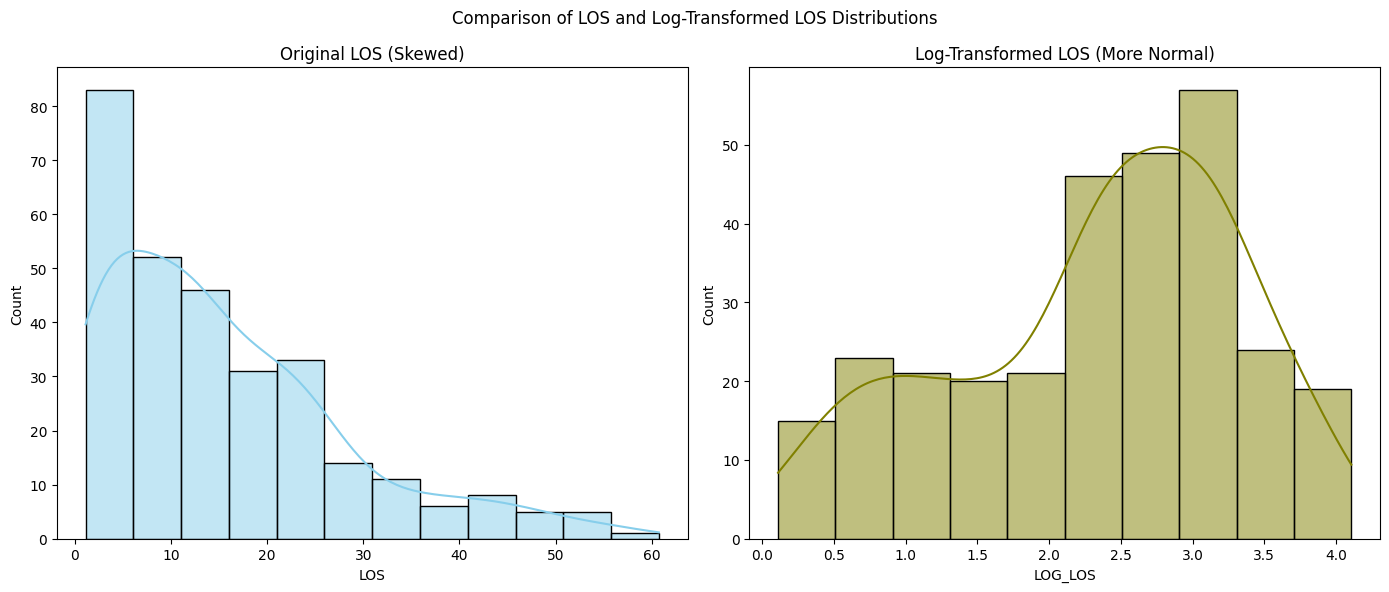

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_merged['LOG_LOS'] = np.log(df_merged['LOS'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Comparison of LOS and Log-Transformed LOS Distributions')

sns.histplot(df_merged['LOS'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Original LOS (Skewed)')

sns.histplot(df_merged['LOG_LOS'], kde=True, ax=axes[1], color='olive')
axes[1].set_title('Log-Transformed LOS (More Normal)')

plt.tight_layout()
plt.show()

In [ ]:
selected_small_id = 220271
selected_mean_id =  284345
selected_big_id = 200375

icu_info = df_icustays[df_icustays['ICUSTAY_ID'] == selected_big_id]
icu_info


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
22486,25628,20190,119413,200375,carevue,CCU,CSRU,57,14,2138-10-15 23:22:54,2138-11-11 12:05:15,26.5294


In [ ]:
starttime = pd.to_datetime(icu_info['INTIME'].iloc[0])
endtime = starttime + pd.Timedelta(hours=24)

starttime, endtime


(Timestamp('2138-10-15 23:22:54'), Timestamp('2138-10-16 23:22:54'))

In [ ]:
print(df_merged.shape)
df_merged.head()

(295, 14)


,SUBJECT_ID,HADM_ID,ICD9_CODE,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ICUSTAY_ID,INTIME,OUTTIME,LOS,GENDER,DOB,age,LOG_LOS
0,114,178393,48283,2146-08-29 01:18:00,2146-09-03 16:06:00,ELECTIVE,258626,2146-08-29 17:59:00,2146-08-31 13:30:00,1.8132,M,2098-05-09,48,0.595093
1,339,112625,48283,2187-04-20 23:10:00,2187-06-19 13:20:00,EMERGENCY,221278,2187-04-20 23:10:50,2187-05-22 16:01:27,31.7018,F,2120-07-17,67,3.456373
2,285,165312,48283,2152-09-21 22:47:00,2152-10-20 15:19:00,EMERGENCY,238023,2152-09-21 22:48:50,2152-10-20 15:19:31,28.6880,M,2107-05-16,45,3.356479
3,605,115545,48283,2197-11-09 12:59:00,2197-11-26 09:36:00,EMERGENCY,248569,2197-11-09 13:00:45,2197-11-26 09:38:48,16.8598,F,1895-04-05,91,2.824932
4,720,171046,48283,2160-02-15 21:44:00,2160-04-07 13:05:00,EMERGENCY,261862,2160-02-15 21:45:04,2160-04-04 19:57:31,48.9253,F,2108-08-25,52,3.890295


In [ ]:
# df_chart_events =  pd.read_csv(data_path + 'chart_events_bronchitis.csv', low_memory=False)
df_chart_events =  pd.read_csv(data_path + 'd_pneumonia.csv', low_memory=False) 
 
print(df_chart_events.shape)      
df_chart_events.head()
# df_merged = pd.merge(df_merged, df_chart_events, how='inner')

# df_merged

(986962, 15)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,170754,1709,127294,207018,220052,2118-01-04 12:15:00,2118-01-04 14:22:00,19783.0,124.0,124.0,mmHg,0.0,0.0,NaN,NaN
1,170755,1709,127294,207018,220210,2118-01-04 12:15:00,2118-01-04 14:22:00,19783.0,30.0,30.0,insp/min,0.0,0.0,NaN,NaN
2,170756,1709,127294,207018,220277,2118-01-04 12:15:00,2118-01-04 14:22:00,19783.0,96.0,96.0,%,0.0,0.0,NaN,NaN
3,170757,1709,127294,207018,220179,2118-01-04 12:20:00,2118-01-04 14:22:00,19783.0,148.0,148.0,mmHg,0.0,0.0,NaN,NaN
4,170758,1709,127294,207018,220180,2118-01-04 12:20:00,2118-01-04 14:22:00,19783.0,69.0,69.0,mmHg,0.0,0.0,NaN,NaN


In [ ]:
# 1. Merge df_merged with CHARTEVENTS (left join to preserve all ICU stays)
df_merged_with_chartevents = pd.merge(
    df_merged[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID','INTIME']],  # Key columns
    df_chart_events[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'VALUENUM','CHARTTIME','VALUEUOM']].drop_duplicates(),
    on=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID'],
    how='left',
    indicator=True  # Adds a column '_merge' to show match status
)
# print(df_merged.columns)
# print(df_merged.shape)

# 2. Identify ICU stays with/without CHARTEVENTS
has_chartevents = df_merged_with_chartevents['_merge'] == 'both'
no_chartevents = df_merged_with_chartevents['_merge'] == 'left_only'

# 3. Get the lists of ICUSTAY_IDs
icu_with_data = df_merged_with_chartevents[has_chartevents]['ICUSTAY_ID'].unique()
icu_without_data = df_merged_with_chartevents[no_chartevents]['ICUSTAY_ID'].unique()

print(f"ICU stays WITH CHARTEVENTS data: {len(icu_with_data)}")
print(f"ICU stays WITHOUT CHARTEVENTS data: {len(icu_without_data)}")

df_merged_with_chartevents.head()

ICU stays WITH CHARTEVENTS data: 140
ICU stays WITHOUT CHARTEVENTS data: 155


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,INTIME,ITEMID,VALUENUM,CHARTTIME,VALUEUOM,_merge
0,114,178393,258626,2146-08-29 17:59:00,211.0,72.0,2146-08-30 10:00:00,BPM,both
1,114,178393,258626,2146-08-29 17:59:00,581.0,102.0,2146-08-30 10:00:00,kg,both
2,114,178393,258626,2146-08-29 17:59:00,618.0,20.0,2146-08-30 10:00:00,BPM,both
3,114,178393,258626,2146-08-29 17:59:00,646.0,98.0,2146-08-30 10:00:00,%,both
4,114,178393,258626,2146-08-29 17:59:00,676.0,38.0,2146-08-30 10:00:00,Deg. C,both


<Axes: xlabel='NORMTIME', ylabel='Count'>

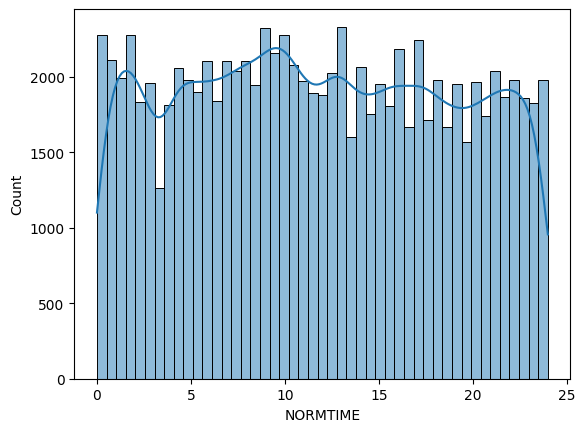

In [ ]:
df_merged_with_chartevents['INTIME'] = pd.to_datetime(df_merged_with_chartevents['INTIME'])
df_merged_with_chartevents['CHARTTIME'] = pd.to_datetime(df_merged_with_chartevents['CHARTTIME'])

df_merged_with_chartevents.isnull().sum()

df_merged_with_chartevents['NORMTIME'] = (df_merged_with_chartevents['CHARTTIME'] - df_merged_with_chartevents['INTIME']).dt.total_seconds() / 3600
df_merged_with_chartevents = df_merged_with_chartevents[(df_merged_with_chartevents['NORMTIME'] < 24) &
                                                         (df_merged_with_chartevents['NORMTIME'] > 0)]
df_merged_with_chartevents.describe()
sns.histplot(df_merged_with_chartevents['NORMTIME'], kde=True)

<Axes: xlabel='NORMTIME', ylabel='Count'>

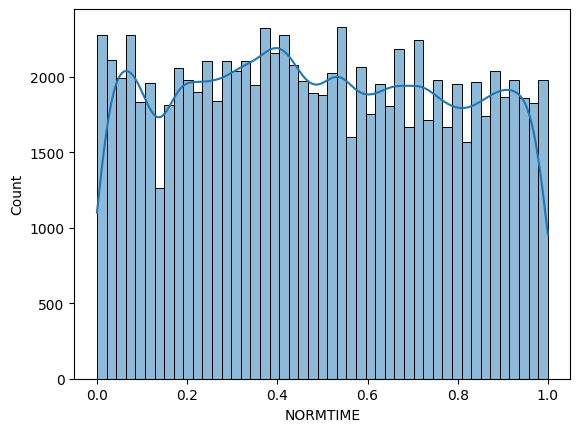

In [ ]:
df_merged_with_chartevents['NORMTIME'] = df_merged_with_chartevents['NORMTIME'] / 24.0

sns.histplot(df_merged_with_chartevents['NORMTIME'], kde=True)

In [ ]:
icu_with_data

array([258626, 221278, 238023, 248569, 261862, 202786, 256557, 207018,
       286609, 274424, 212945, 226191, 271827, 248514, 215159, 265851,
       211988, 291691, 291479, 231640, 200696, 275530, 216379, 200612,
       238708, 249772, 257533, 274718, 277079, 274326, 276330, 293504,
       214175, 241783, 213339, 293738, 244528, 270380, 245096, 262172,
       202274, 289137, 292713, 233794, 250668, 292101, 200387, 295684,
       285353, 243197, 215264, 206448, 274960, 253774, 270240, 275598,
       223435, 212116, 299321, 295935, 295195, 210014, 241032, 254474,
       235444, 247111, 232180, 251832, 210160, 287844, 217726, 243478,
       278016, 240714, 239944, 269593, 273636, 251586, 282753, 277323,
       268113, 270748, 214087, 271393, 284497, 231855, 290349, 214505,
       249469, 209543, 279995, 231719, 230131, 288087, 201921, 289186,
       228565, 258054, 211435, 280339, 241689, 236989, 254093, 251009,
       230391, 264601, 219048, 213653, 259979, 278100, 234233, 232142,
      

In [ ]:
df_merged_with_chartevents.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'INTIME', 'ITEMID', 'VALUENUM',
       'CHARTTIME', 'VALUEUOM', '_merge', 'NORMTIME'],
      dtype='object')

<Axes: xlabel='age', ylabel='Count'>

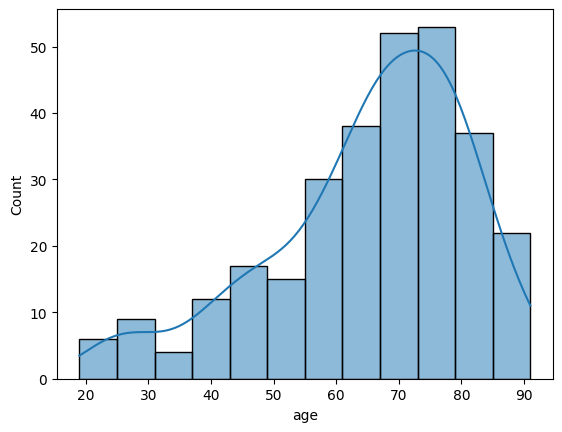

In [ ]:
sns.histplot(df_merged['age'], kde=True)

In [ ]:
df_merged.describe().T

,count,mean,min,25%,50%,75%,max,std
SUBJECT_ID,295.0,33410.108475,114.0,11283.5,25541.0,49267.5,99715.0,28729.043193
HADM_ID,295.0,150115.684746,100395.0,124995.5,151960.0,174117.5,199845.0,27742.232113
ADMITTIME,295,2150-08-11 23:14:07.525424128,2100-11-30 02:51:00,2124-03-16 11:56:00,2150-04-21 07:15:00,2174-09-16 00:36:00,2207-12-13 20:56:00,NaN
ICUSTAY_ID,295.0,252478.494915,200387.0,231240.5,253774.0,275776.0,299728.0,28280.572249
LOS,295.0,15.485045,1.1159,5.09495,12.464,21.72955,60.7469,12.665445
DOB,295,2079-08-14 19:16:52.881355776,1805-12-07 00:00:00,2056-06-22 00:00:00,2088-03-22 00:00:00,2110-03-24 00:00:00,2173-02-23 00:00:00,NaN
age,295.0,65.220339,19.0,57.0,68.0,77.0,91.0,15.949397
LOG_LOS,295.0,2.337022,0.109661,1.628242,2.522844,3.078669,4.106716,0.995463


In [ ]:
print(df_merged_with_chartevents.shape)
df_merged_with_chartevents.head()
df_merged_with_chartevents.drop(columns='_merge')
# df_merged_with_chartevents.to_csv('norm_pneumonia.csv', index=False)

(92007, 10)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,INTIME,ITEMID,VALUENUM,CHARTTIME,VALUEUOM,NORMTIME
0,114,178393,258626,2146-08-29 17:59:00,211.0,72.0,2146-08-30 10:00:00,BPM,0.667361
1,114,178393,258626,2146-08-29 17:59:00,581.0,102.0,2146-08-30 10:00:00,kg,0.667361
2,114,178393,258626,2146-08-29 17:59:00,618.0,20.0,2146-08-30 10:00:00,BPM,0.667361
3,114,178393,258626,2146-08-29 17:59:00,646.0,98.0,2146-08-30 10:00:00,%,0.667361
4,114,178393,258626,2146-08-29 17:59:00,676.0,38.0,2146-08-30 10:00:00,Deg. C,0.667361
...,...,...,...,...,...,...,...,...,...
986480,97567,186941,231717,2199-12-03 13:49:15,224684.0,500.0,2199-12-04 00:00:00,mL,0.424132
986481,97567,186941,231717,2199-12-03 13:49:15,224685.0,508.0,2199-12-04 00:00:00,mL,0.424132
986482,97567,186941,231717,2199-12-03 13:49:15,224687.0,8.1,2199-12-04 00:00:00,L/min,0.424132
986483,97567,186941,231717,2199-12-03 13:49:15,224688.0,16.0,2199-12-04 00:00:00,insp/min,0.424132


/Users/codrutajucan/Documents/repos/mimic3-length-of-stay-prediction/.venv/lib/python3.13/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


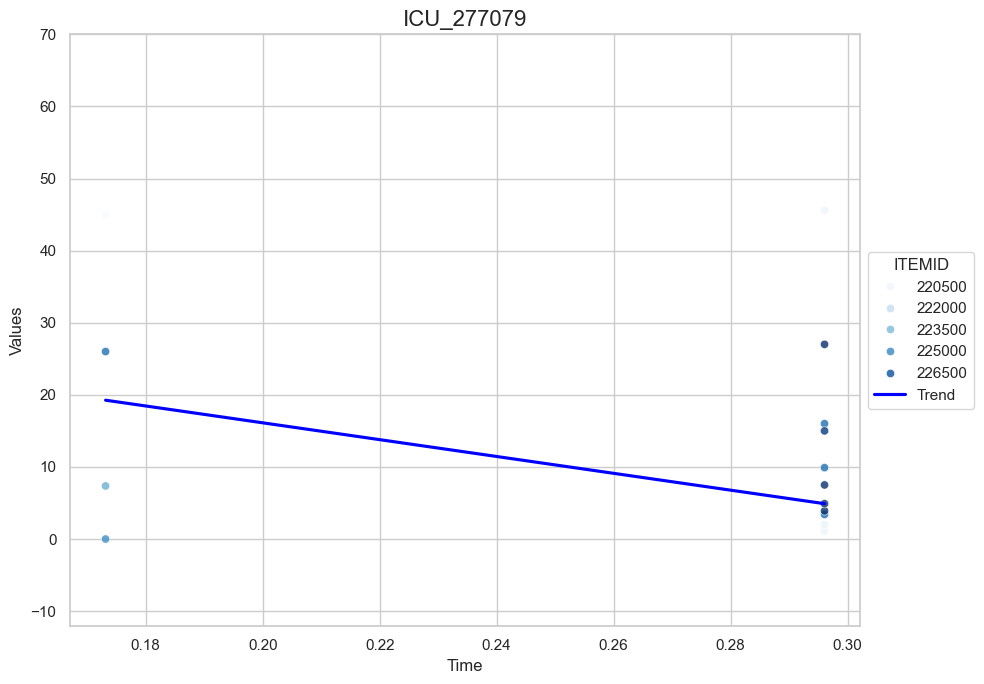

In [ ]:
# Load the dataset
df = pd.read_csv("./data_sets/norm_pneumonia.csv")

# Filter by a specific ICU stay (you can change this ID)
icu_id = 277079
filtered = df[df["ICUSTAY_ID"] == icu_id]

# Set up the plot
plt.figure(figsize=(10, 7))
sns.set(style="whitegrid")

# Scatter plot with hue by ITEMID
scatter = sns.scatterplot(
    data=filtered,
    x="NORMTIME",
    y="VALUENUM",
    hue="ITEMID",
    palette="Blues",
    alpha=0.8
)

# Trend line (not grouped by ITEMID)
sns.regplot(
    data=filtered,
    x="NORMTIME",
    y="VALUENUM",
    scatter=False,
    lowess=True,
    color="blue",
    label="Trend"
)

plt.ylim(top=70)

# Adjust legend
plt.legend(title="ITEMID", loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f"ICU_{icu_id}", fontsize=16)
plt.xlabel("Time")
plt.ylabel("Values")
plt.tight_layout()
plt.show()